In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

In [4]:
df = pd.read_csv("../DATA/train forecast sticker sales.csv")

In [5]:
df.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [6]:
df = df.sort_index()
df_final = df.copy()

In [7]:
df.date = pd.to_datetime(df.date)
df.index = df.date
df = df.drop('date', axis=1)

In [8]:
df['num_sold'].mean(numeric_only=True)

752.527381937006

In [9]:
df['num_sold'] = np.round(df['num_sold'].fillna(df.groupby('product')['num_sold'].transform('mean')), 2)

In [10]:
df_plot = df.groupby('date')['num_sold'].mean(numeric_only=True)

<Axes: xlabel='date'>

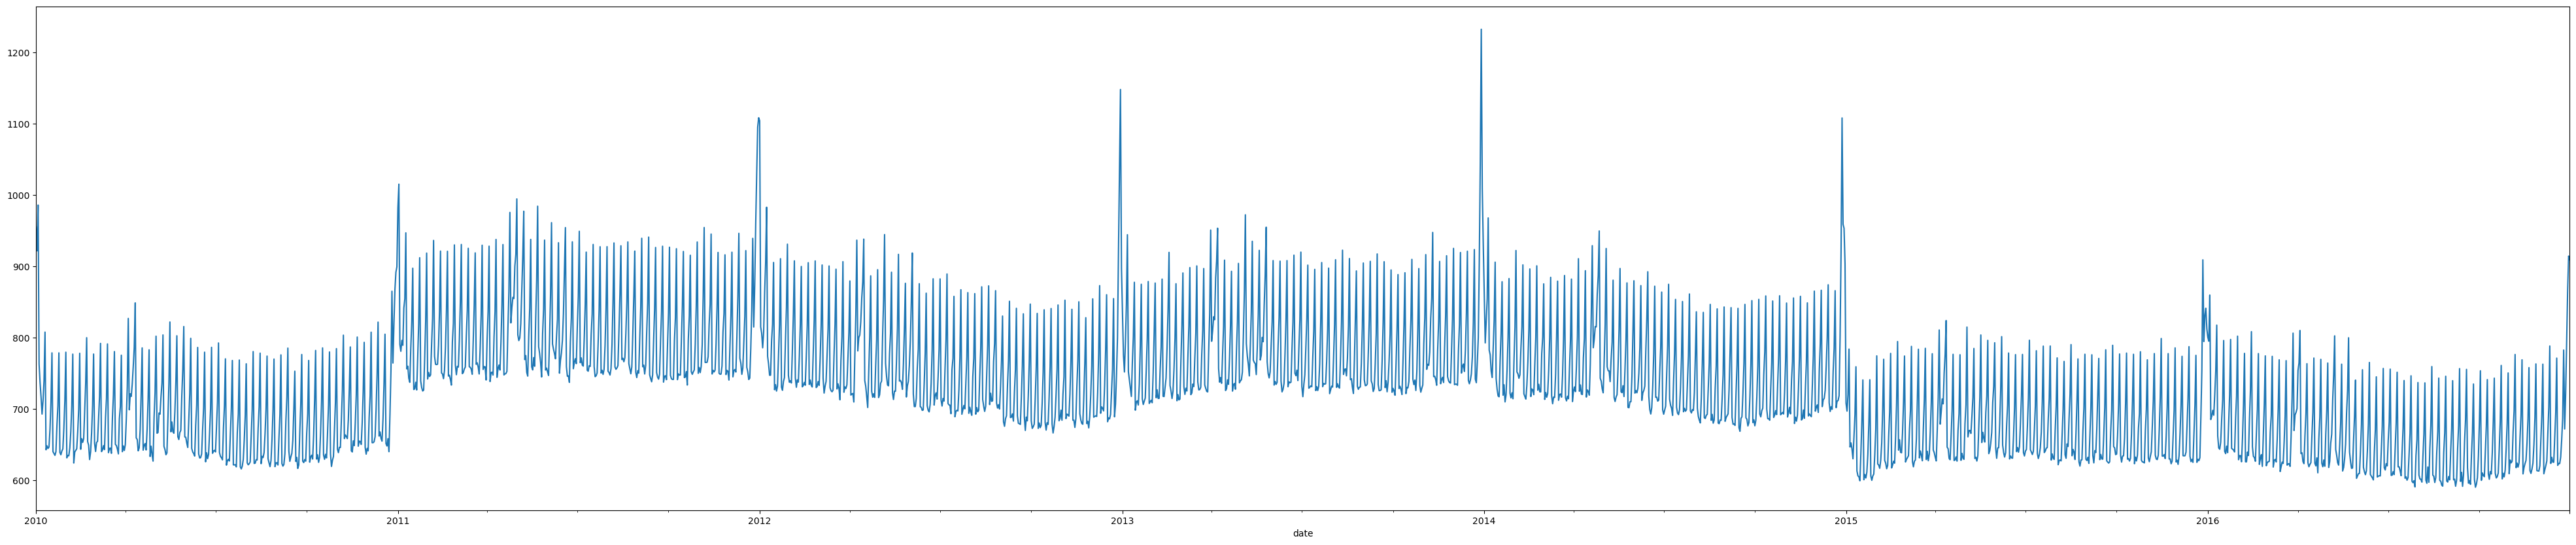

In [12]:
df_plot.plot(figsize=(50, 10))

In [17]:
from statsmodels.api import tsa

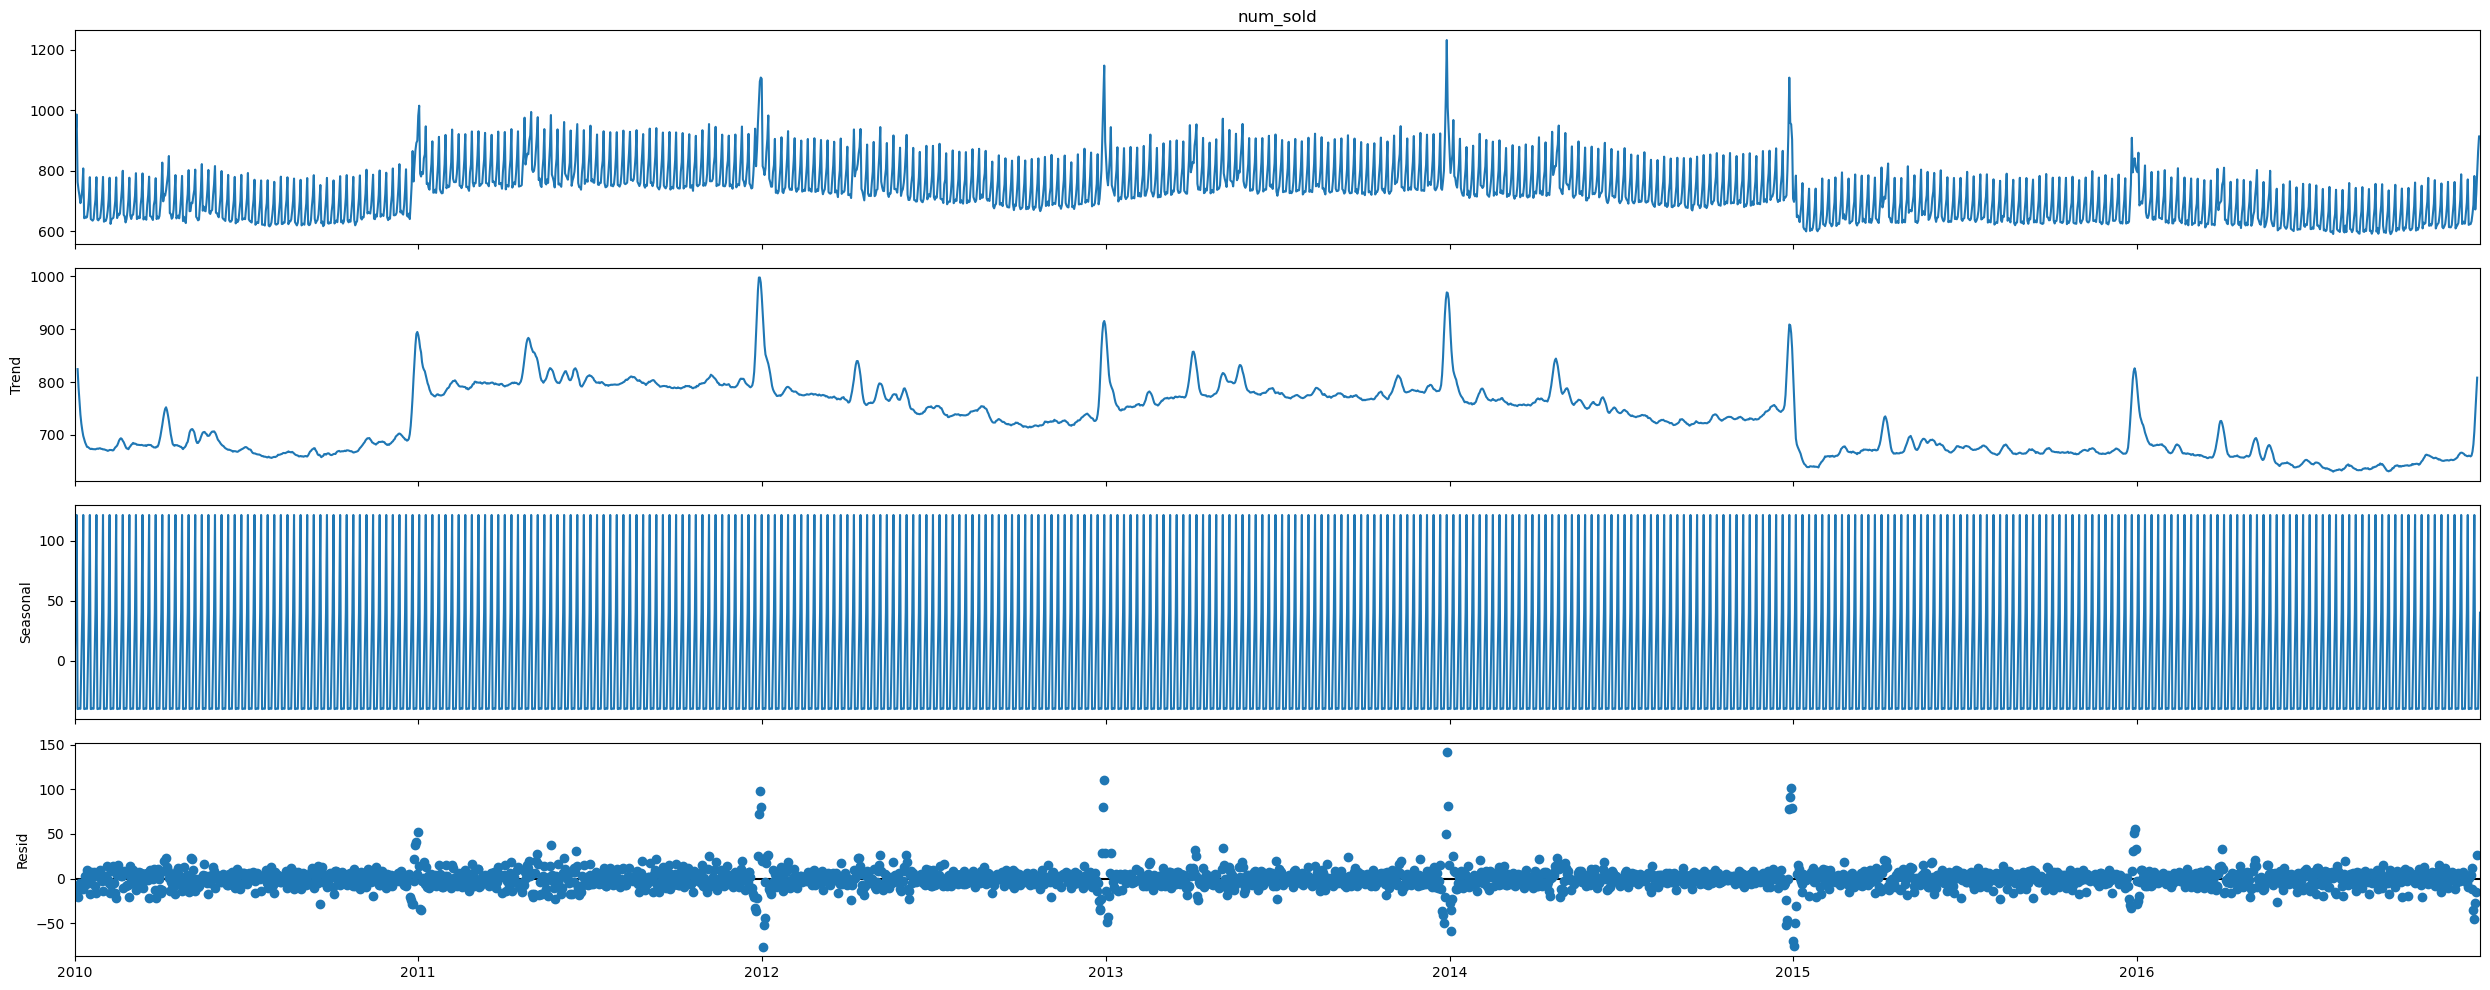

In [21]:
res = tsa.seasonal_decompose(df_plot)
plt.rc('figure', figsize=(25, 10))
res_plot = res.plot()

In [22]:
from statsmodels.tsa import stattools

In [23]:
df_stat = stattools.adfuller(df_plot, regression='n')
print(f'The augmented Dickey_Fuller test statistic {df_stat[0]:.4f} \np_value {df_stat[1]:.4f} \ncritical_criteries {df_stat[4]}')
if df_stat[0] > df_stat[4]['5%']:
    print('Есть единичные корни, ряд нестационарен')
else:
    print('Единичных корней нет, ряд стационарен')

The augmented Dickey_Fuller test statistic -0.0441 
p_value 0.6694 
critical_criteries {'1%': -2.5666235831218227, '5%': -1.9411066051021868, '10%': -1.6167155244564084}
Есть единичные корни, ряд нестационарен


In [24]:
df_copy = df.copy()
df_copy['month'] = df_copy.index.month
df_copy['day'] = df_copy.index.day
df_copy['year'] = df_copy.index.year
df_copy['day_of_week'] = df_copy.index.dayofweek
df_obj = df_copy.select_dtypes(include=object)
df_obj = pd.get_dummies(df_obj, drop_first=True, dtype=int)
df_num = df_copy[['id', 'day', 'day_of_week', 
                   'month', 'year', 'num_sold']]
df_copy = pd.concat([df_obj, df_num], axis=1)

In [126]:
df_copy.head()

,country_Finland,country_Italy,country_Kenya,country_Norway,country_Singapore,store_Premium Sticker Mart,store_Stickers for Less,product_Kaggle,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode,id,day,day_of_week,month,year,num_sold
date,,,,,,,,,,,,,,,,,
2010-01-01,0,0,0,0,0,0,0,0,0,0,0,0,1,4,1,2010,197.48
2010-01-01,0,0,0,0,0,0,0,1,0,0,0,1,1,4,1,2010,973.00
2010-01-01,0,0,0,0,0,0,0,0,1,0,0,2,1,4,1,2010,906.00
2010-01-01,0,0,0,0,0,0,0,0,0,1,0,3,1,4,1,2010,423.00
2010-01-01,0,0,0,0,0,0,0,0,0,0,1,4,1,4,1,2010,491.00


In [138]:
#train_size = int(len(df_copy) * 0.8)
X = df_copy.drop('num_sold', axis=1)
y = df_copy['num_sold']

In [140]:
tscv = TimeSeriesSplit(n_splits=5)

errors = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    lin_model = LinearRegression()
    lin_model.fit(X_train, y_train)
    y_pred = lin_model.predict(X_test)
    errors.append(mean_absolute_percentage_error(y_pred, y_test))

np.mean(errors)

0.7288385930232343

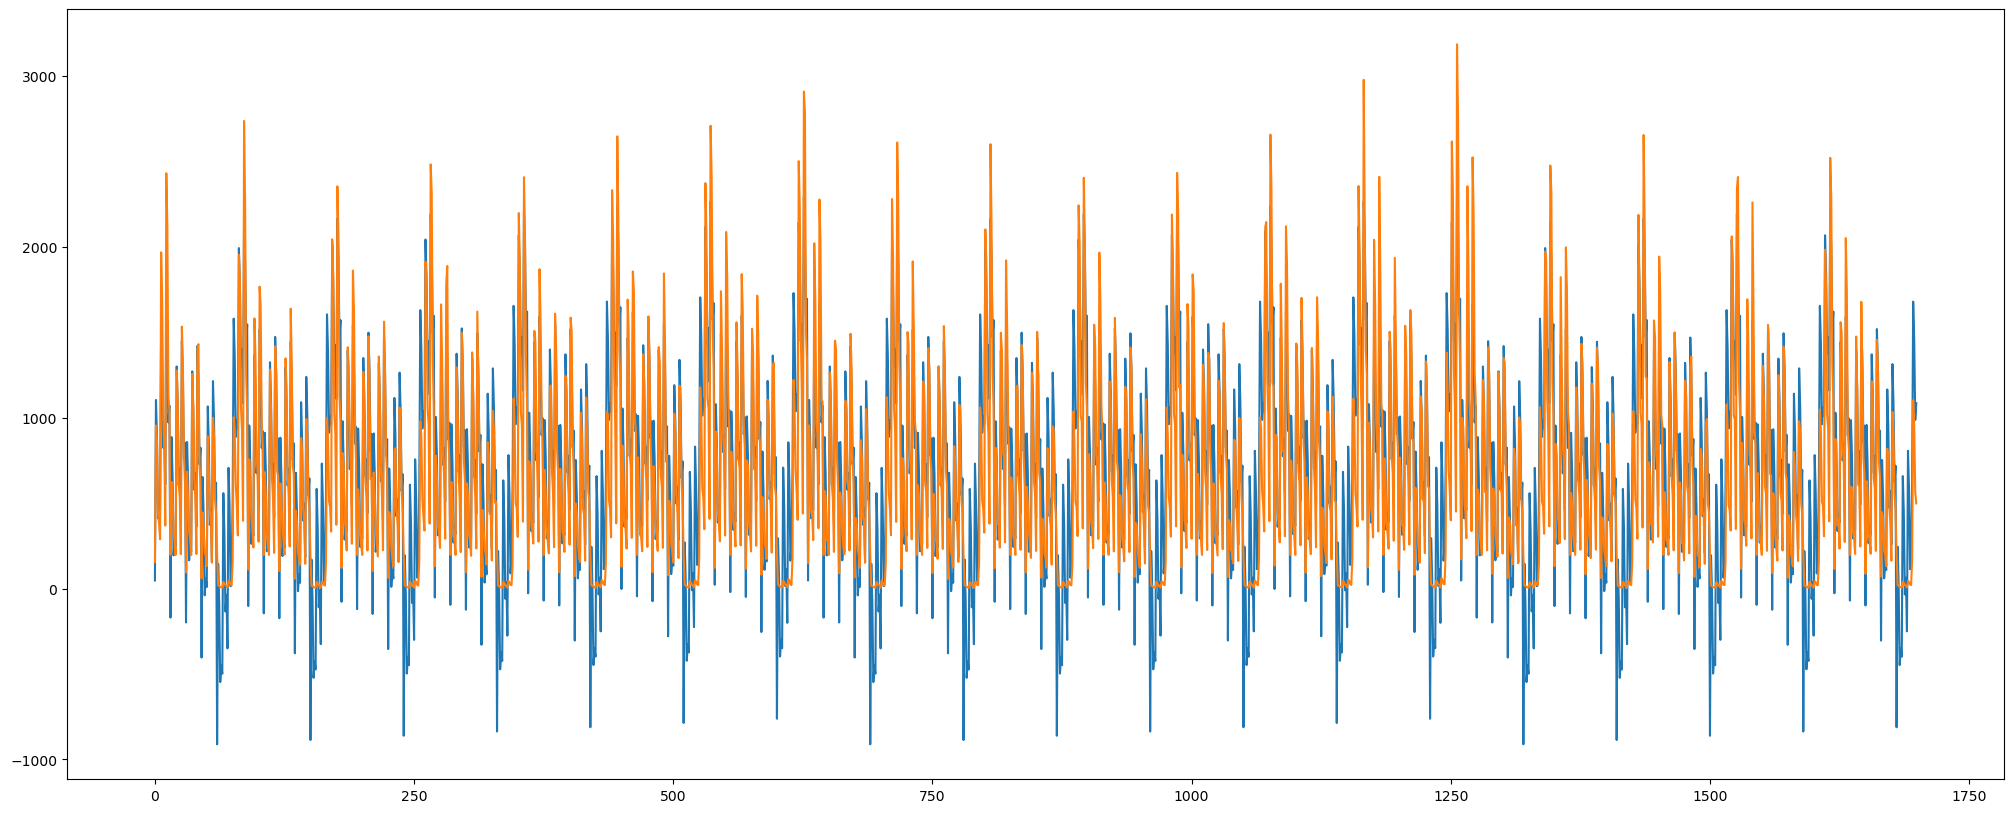

In [142]:
plt.plot(y_pred[:1700])
plt.plot(y_test[:1700])

In [144]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [146]:
tscv = TimeSeriesSplit(n_splits=5)

errors_tree = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    tree_model = DecisionTreeRegressor()
    tree_model.fit(X_train, y_train)
    y_pred_tree = tree_model.predict(X_test)
    errors_tree.append(mean_absolute_percentage_error(y_pred_tree, y_test))

np.mean(errors)

0.7288385930232343

# Final_model

In [148]:
class NewFeatureGenerator(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        X_transformed['date'] = pd.to_datetime(X_transformed['date'])
        X_transformed.index = X_transformed['date']
        X_transformed = X_transformed.drop('date', axis=1)
        X_transformed['month'] = X_transformed.index.month
        X_transformed['day'] = X_transformed.index.day
        X_transformed['year'] = X_transformed.index.year
        X_transformed['day_of_week'] = X_transformed.index.dayofweek
        
        X_transformed['day_sin'] = np.sin(2 * np.pi * X_transformed['day'] / 365.0)
        X_transformed['day_cos'] = np.cos(2 * np.pi * X_transformed['day'] / 365.0)
        X_transformed['month_sin'] = np.sin(2 * np.pi * X_transformed['month'] / 12.0)
        X_transformed['month_cos'] = np.cos(2 * np.pi * X_transformed['month'] / 12.0)
        X_transformed['year_sin'] = np.sin(2 * np.pi * X_transformed['year'] / 7.0)
        X_transformed['year_cos'] = np.cos(2 * np.pi * X_transformed['year'] / 7.0)

        # Group Calculation
        X_transformed['Group'] = (X_transformed['year'] - 2010) * 48 + X_transformed['month'] * 4 + X_transformed['day'] // 7
        #df[['Month', 'Day', 'week', 'Year']] = df[['Month', 'Day', 'week', 'Year']].astype('object')
        X_transformed = X_transformed[['id', 'day', 'day_of_week', 'month',
                                       'year', 'day_sin', 'day_cos',
                                       'month_sin','month_cos', 'year_sin', 
                                       'year_cos']]
        return X_transformed

In [150]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [152]:
pipeline = Pipeline([('NewFeatureGenerator', NewFeatureGenerator()), 
                     ('SimpleImputer', SimpleImputer(strategy='mean')),
                     ('standard', StandardScaler()),
                     ('svm_model', LinearRegression())])

In [154]:
df_final = df_final.dropna()

In [156]:
size = int(len(df_final) * 0.8)
train_1 = df_final[:size]
X_train_1 = train_1.drop('num_sold', axis=1)
y_train_1 = train_1['num_sold']
test_1 = df_final[size:]
X_test_1 = test_1.drop('num_sold', axis=1)
y_test_1 = test_1['num_sold']

In [158]:
pipeline.fit(X_train_1, y_train_1)

Pipeline(steps=[('NewFeatureGenerator', NewFeatureGenerator()),
                ('SimpleImputer', SimpleImputer()),
                ('standard', StandardScaler()),
                ('svm_model', LinearRegression())])

In [160]:
pred_final = pipeline.predict(X_test_1)

In [162]:
mean_absolute_percentage_error(pred_final, y_test_1)

0.6246164981207998

In [164]:
train_data = pd.read_csv('../DATA/train forecast sticker sales.csv')
final_data = pd.read_csv("../DATA/test forecast sticker sales.csv")
example = pd.read_csv('../DATA/sample_submission forecast sticker sales.csv')

In [166]:
final_data.head()

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode


In [168]:
example.head()

,id,num_sold
0,230130,100
1,230131,100
2,230132,100
3,230133,100
4,230134,100


In [170]:
pred_final = pd.DataFrame(pipeline.predict(final_data), columns=['num_sold'])
pred_final.num_sold = np.round(pred_final.num_sold, 1)

In [172]:
my_predictions = pd.concat([final_data, pred_final], axis=1)

In [174]:
my_predictions = my_predictions[['id', 'num_sold']]

In [176]:
my_predictions.to_csv('Forecasting_Sticker_Sales.csv')

In [178]:
from joblib import dump

In [180]:
dump(pipeline, 'Forecasting_Sticker_Sales.joblib')

['Forecasting_Sticker_Sales.joblib']